In [2]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [625]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    wind_speeds = []

    for path in paths:
        wind_speeds = np.append(wind_speeds, int(path['maxwind']))

    highest_wind = max(wind_speeds)
    
    return highest_wind

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 100, 100)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 100, 100)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :100, :100]
    rgb_array = rgb_array.reshape(1, 48, 100, 100)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/noaa_sst_*.npy'

    sst = glob.glob(file, recursive = True)
    sst.sort()
    sst = sst[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, sst[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    
def createWindMap(profile):
    # return nparray(1, 100, 100)
    # hurricane center is  at (49,49),   each direction expand by 50 miles
    
    res = np.zeros((100, 100))
    
    maxwindradius = min(int(float(profile['maxwindradius'])/2), 49)
    maxwind = float(profile['maxwind'])
    
    keys = []
    for it in profile.keys():
        if 'kt' in it:
            keys.append(it)        
    keys.sort()
    
    for it in keys:
        if "ne" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50-i-1,  50 +j] = max(0, float(it[:-4]))
        elif "se" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50 + i,  50 +j] = max(0, float(it[:-4]))
        elif "nw" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50-i-1,  50-j-1] = max(0, float(it[:-4]))
        elif "sw" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50 + i,  50-j-1] = max(0, float(it[:-4]))
                        
    for i in range(-maxwindradius, maxwindradius):
        for j in range(-maxwindradius, maxwindradius):
            res[49 + i, 49 + j] = maxwind
    
    res = np.expand_dims(res, axis = 0)
                    
    return res
    

In [626]:
def getCategory(wind_speed): # based on the Saffir-Simpson Scale for hurricane classification
    
    thresholds = [('TD', 33), ('TS', 63), ('Category_1', 82), ('Category_2', 95), ('Category_3', 112), ('Category_4', 136)]
    
    for it in thresholds:
        if wind_speed <= it[1]:
            return it[0]
    return thresholds[-1][0]

def selectDay(cat_dictionary):
    pick_days = []
    for key in cat_dictionary.keys():
        index = round(len(cat_dictionary[key])/2)-1
        day_list = cat_dictionary[key]
        day = day_list[index]
        pick_days = np.append(pick_days, day)
    return pick_days

def get100by100(three_d_tensor):
    new_tensor = three_d_tensor[:, :100, :100]
    return new_tensor    

def getStageByDay(folder, day):
    
    imerg_names = folder + '/imerg_precipitation_' + day + '_*.npy'
    sst_names = folder + '/noaa_sst_' + day + '*.npy'
    rgb_names = folder + '/wavelet_rgb_' + day + '*.npy'
    
    profile_name = folder + '/profile.json'
    f = open(profile_name)
    profile = json.load(f)
    paths = profile['path']

    imergs = glob.glob(imerg_names, recursive = True)
    ssts = glob.glob(sst_names, recursive = True)
    rgbs = glob.glob(rgb_names, recursive = True)
    
    imerg_array = np.zeros((100, 100))
    for imerg in imergs:
        imerg_array = imerg_array + np.load(imerg)

    imerg_array = imerg_array.reshape(1, 100, 100)
    imerg_array = imerg_array / len(imergs)
    
    if (not rgbs) or (not ssts):
        print("no rgbs or ssts: ", folder, day)
        return None
    
    sst_array = np.load(ssts[0])
    
    if (not sizeCheck(sst_array)):      
        print("sst shape invalid: ", folder, day)
        return None

    rgb_array = np.load(rgbs[0])
    
    rgb_array = get100by100(rgb_array)
        
        
    selected_day = {}

    for path in paths:
        if path['date'] == int(day):
            selected_day = path
            break

    wind_array = createWindMap(selected_day)
    
    stage_array = imerg_array
    stage_array = np.append(stage_array, sst_array, axis = 0)
    stage_array = np.append(stage_array, rgb_array, axis = 0)
    stage_array = np.append(stage_array, wind_array, axis = 0)
    stage_array = np.expand_dims(stage_array, axis = 0)

    return stage_array

def sizeCheck(three_d_tensor): # size check should happen after stage data is collected
    shape = three_d_tensor.shape
    if (shape[1] != 100) or (shape[2] != 100):
        return False
    else:
        return True
    
def populateStage(stage, step):
    if step is None:
        return stage
    if stage is None:
        stage = step
    else:
        stage = np.append(stage, step, axis = 0)
    return stage

In [649]:
# outdated data collection methodology -- moved on as of 11/08/2022
def OUTDATED_DATA_COLLECTION():
    highest_wind = np.empty([0])
    imerg_precip = np.empty([1, 10, 100, 100])
    skin_temp = np.empty([1, 4, 100, 100])
    dwt_rgb = np.empty([1, 48, 100, 100])

    all_folders = glob.glob('/home/fun/data/AL*20*')
    all_folders.sort()

    len_fail = 0
    land_fail = 0

    for folder in all_folders:
        imerg_names = folder + '/imerg_precipitation_*.npy'
        sst_names = folder + '/noaa_sst_*.npy'
        rgb_names = folder + '/wavelet_rgb_*.npy'

        if not lenCheck(imerg_names, sst_names, rgb_names):
            print("skipping lenCheck ", folder)
            len_fail += 1
            continue
        if not landCheck(folder, imerg_names, sst_names, rgb_names):
            print("skipping landCheck ", folder)
            land_fail += 1
            continue

        imerg_precip = np.append(imerg_precip, get_imerg(imerg_names), axis = 0) # X data (train class)
        skin_temp = np.append(skin_temp, get_sst(sst_names), axis = 0) # X data (train class)
        dwt_rgb = np.append(dwt_rgb, get_rgb(rgb_names), axis = 0)

        highest_wind = np.append(highest_wind, get_max_wind(folder)) # Y data (target class)

    imerg_precip = imerg_precip[1:]
    skin_temp = skin_temp[1:]
    dwt_rgb = dwt_rgb[1:]

    print(imerg_precip.shape, skin_temp.shape, dwt_rgb.shape, highest_wind.shape)
    print("len_fail: ", len_fail)
    print("land_fail: ", land_fail)
    
    return None # OUTDATED DATA COLLECTION METHOD AS OF 11/08/2022

In [650]:
def completeDataCollection(globname, max_wind_param): # NEW DATA COLLECTION METHOD - SORT INTO STAGES

    folders = glob.glob(globname, recursive = True)
    # AL032000, failed rgb glob (no modis satellite data for that day)
    # AL242005, failed ssts glob (no sst satellite data for that day)
    stage_1 = None
    stage_2 = None
    stage_3 = None
    highest_wind = None

    for folder in folders:
        name = folder + '/profile.json'
        f = open(name)
        prof = json.load(f)
        paths = prof['path']

        cats = {} # dictionary with categories as keys, days as values.
        # used to extract day values based on hurricane category (stage)

        for path in paths:
            if int(path['maxwind']) < int(max_wind_param): # only select hurricanes with wind speed at least max_wind_param
                continue
            test = getCategory(int(path['maxwind']))

            if test not in cats.keys():
                cats[test] = []
            cats[test].append(str(path['date']))

        for key in cats.keys():
            cats[key] = list(set(cats[key]))
            cats[key].sort()

        days = selectDay(cats)
        print(cats, days)
        if len(days) < 3:
            print("not enough categories: ", folder)
            continue

        print("valid folder: ", folder)


        step_1 = getStageByDay(folder, days[0])
        step_2 = getStageByDay(folder, days[1])
        step_3 = getStageByDay(folder, days[2])


        if (step_1 is None) or (step_2 is None) or (step_3 is None):
            print("size not fit: ", folder)
            continue

        stage_1 = populateStage(stage_1, step_1)
        stage_2 = populateStage(stage_2, step_2)
        stage_3 = populateStage(stage_3, step_3)

        highest_wind = np.append(highest_wind, get_max_wind(folder))

    highest_wind = highest_wind[1:]
    print(stage_1.shape, stage_2.shape, stage_3.shape, highest_wind.shape)
    
    return stage_1, stage_2, stage_3, highest_wind



In [651]:
stage_1, stage_2, stage_3, highest_wind = completeDataCollection('/home/fun/data/AL*20*', 0)

{'TD': ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809'], 'TS': ['20040809', '20040810', '20040811', '20040812']} ['20040806' '20040810']
not enough categories:  /home/fun/data/AL022004
{'TD': ['20040813', '20040820', '20040821', '20040822', '20040823', '20040824'], 'TS': ['20040814', '20040818', '20040819', '20040820'], 'Category_1': ['20040815', '20040818'], 'Category_2': ['20040815', '20040816', '20040817']} ['20040821' '20040818' '20040815' '20040816']
valid folder:  /home/fun/data/AL042004
{'TD': ['20040813', '20040814'], 'TS': ['20040814', '20040815']} ['20040813' '20040814']
not enough categories:  /home/fun/data/AL052004
{'TD': ['20040827', '20040828'], 'TS': ['20040828', '20040829'], 'Category_1': ['20040829']} ['20040827' '20040828' '20040829']
valid folder:  /home/fun/data/AL072004
{'TD': ['20040827', '20040828', '20040829'], 'TS': ['20040829', '20040830', '20040831']} ['20040828' '20040830']
not enough categories:  /home/fun/data/AL082004


{'TD': ['20020917', '20020918'], 'TS': ['20020918', '20020919']} ['20020917' '20020918']
not enough categories:  /home/fun/data/AL112002
{'TD': ['20020920', '20020921', '20020930', '20021001', '20021005', '20021006', '20021008', '20021009', '20021010', '20021011'], 'TS': ['20020921', '20020922', '20020923', '20020924', '20020925', '20020928', '20020929', '20020930', '20021001', '20021002', '20021003', '20021004', '20021005', '20021006', '20021007', '20021008', '20021011'], 'Category_1': ['20020925', '20020926', '20020927', '20020928']} ['20021005' '20020930' '20020926']
valid folder:  /home/fun/data/AL122002
{'TD': ['20020921', '20020922', '20020926', '20020927'], 'TS': ['20020923', '20020924', '20020925', '20020926', '20020927', '20020928', '20020929', '20020930'], 'Category_1': ['20020930']} ['20020922' '20020926' '20020930']
valid folder:  /home/fun/data/AL132002
{'TD': ['20021014', '20021015', '20021016']} ['20021015']
not enough categories:  /home/fun/data/AL142002
{'TD': ['200304

{'TD': ['20050721'], 'TS': ['20050722', '20050723', '20050724', '20050725', '20050726', '20050727', '20050728', '20050729', '20050730', '20050731']} ['20050721' '20050726']
not enough categories:  /home/fun/data/AL062005
{'TD': ['20050723', '20050724'], 'TS': ['20050724']} ['20050723' '20050724']
not enough categories:  /home/fun/data/AL072005
{'TD': ['20050802', '20050803', '20050811', '20050812', '20050813', '20050814'], 'TS': ['20050803', '20050804', '20050805', '20050806', '20050807', '20050808', '20050809', '20050810', '20050811']} ['20050811' '20050806']
not enough categories:  /home/fun/data/AL082005
{'TD': ['20050804', '20050805', '20050806', '20050807', '20050808', '20050809', '20050810'], 'TS': ['20050807', '20050808', '20050811', '20050812', '20050813', '20050814', '20050818'], 'Category_1': ['20050815', '20050816', '20050817'], 'Category_2': ['20050816']} ['20050807' '20050812' '20050816' '20050816']
valid folder:  /home/fun/data/AL092005
{'TD': ['20050813', '20050814', '20

{'TD': ['20070815'], 'TS': ['20070815', '20070816']} ['20070815' '20070815']
not enough categories:  /home/fun/data/AL052007
{'TD': ['20070831'], 'TS': ['20070901']} ['20070831' '20070901']
not enough categories:  /home/fun/data/AL062007
{'TS': ['20070908', '20070909']} ['20070908']
not enough categories:  /home/fun/data/AL072007
{'TD': ['20070912', '20070913', '20070915', '20070916', '20070917', '20070918'], 'TS': ['20070913', '20070914', '20070915']} ['20070915' '20070914']
not enough categories:  /home/fun/data/AL082007
{'TD': ['20070912'], 'TS': ['20070912', '20070913'], 'Category_1': ['20070913']} ['20070912' '20070912' '20070913']
valid folder:  /home/fun/data/AL092007
{'TD': ['20070921']} ['20070921']
not enough categories:  /home/fun/data/AL102007
{'TD': ['20070923', '20070924'], 'TS': ['20070923', '20070924']} ['20070923' '20070923']
not enough categories:  /home/fun/data/AL112007
{'TD': ['20070925', '20070929'], 'TS': ['20070925', '20070926', '20070927', '20070928', '20070929

{'TD': ['20100824', '20100825'], 'TS': ['20100825', '20100826', '20100827', '20100828', '20100829', '20100904'], 'Category_1': ['20100829', '20100903', '20100904'], 'Category_2': ['20100830', '20100903'], 'Category_3': ['20100830', '20100901', '20100902'], 'Category_4': ['20100830', '20100831', '20100901', '20100902']} ['20100824' '20100827' '20100903' '20100830' '20100901' '20100831']
valid folder:  /home/fun/data/AL072010
{'TD': ['20100830', '20100904'], 'TS': ['20100830', '20100831', '20100901', '20100902', '20100903', '20100904']} ['20100830' '20100901']
not enough categories:  /home/fun/data/AL082010
{'TD': ['20100901', '20100902', '20100903', '20100904', '20100905', '20100906', '20100907', '20100908'], 'TS': ['20100901']} ['20100904' '20100901']
not enough categories:  /home/fun/data/AL092010
{'TD': ['20100904', '20100905', '20100906'], 'TS': ['20100906', '20100907']} ['20100905' '20100906']
not enough categories:  /home/fun/data/AL102010
{'TD': ['20100908', '20100909', '20100910

{'TD': ['20120820', '20120821'], 'TS': ['20120821', '20120822', '20120823', '20120824', '20120825']} ['20120820' '20120822']
not enough categories:  /home/fun/data/AL092012
{'TD': ['20120821', '20120822', '20120823', '20120824'], 'TS': ['20120823']} ['20120822' '20120823']
not enough categories:  /home/fun/data/AL102012
{'TD': ['20120828'], 'TS': ['20120829', '20120830', '20120901', '20120902', '20120903'], 'Category_1': ['20120830', '20120831', '20120901'], 'Category_2': ['20120831']} ['20120828' '20120830' '20120831' '20120831']
valid folder:  /home/fun/data/AL112012
{'TD': ['20120828', '20120829', '20120830'], 'TS': ['20120830', '20120831', '20120901', '20120902', '20120903', '20120904', '20120905', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912'], 'Category_1': ['20120905', '20120906', '20120907', '20120910', '20120911']} ['20120829' '20120904' '20120906']
valid folder:  /home/fun/data/AL122012
{'TD': ['20120902', '20120903', '20120904', '20120912'], 'TS': ['

{'TS': ['20150824', '20150825', '20150826', '20150827', '20150828']} ['20150825']
not enough categories:  /home/fun/data/AL052015
{'TD': ['20150830', '20150904', '20150905', '20150906'], 'TS': ['20150830', '20150901', '20150902', '20150903', '20150904', '20150905'], 'Category_1': ['20150831', '20150901']} ['20150904' '20150902' '20150831']
valid folder:  /home/fun/data/AL062015
{'TD': ['20150905', '20150908', '20150909'], 'TS': ['20150905', '20150906', '20150907', '20150908']} ['20150908' '20150906']
not enough categories:  /home/fun/data/AL072015
{'TD': ['20150908'], 'TS': ['20150909', '20150910', '20150911']} ['20150908' '20150910']
not enough categories:  /home/fun/data/AL082015
{'TD': ['20150915', '20150916', '20150917', '20150918', '20150919']} ['20150916']
not enough categories:  /home/fun/data/AL092015
{'TD': ['20150915', '20150916', '20150917', '20150918', '20150924', '20150925', '20150926', '20150927', '20150928'], 'TS': ['20150919', '20150920', '20150921', '20150922', '201509

{'TD': ['20180705', '20180706', '20180707', '20180708', '20180715', '20180716', '20180717'], 'TS': ['20180708', '20180709', '20180710', '20180712', '20180713', '20180714', '20180715'], 'Category_1': ['20180710', '20180711', '20180712'], 'Category_2': ['20180711']} ['20180708' '20180712' '20180711' '20180711']
valid folder:  /home/fun/data/AL032018
no rgbs or ssts:  /home/fun/data/AL032018 20180708
no rgbs or ssts:  /home/fun/data/AL032018 20180712
no rgbs or ssts:  /home/fun/data/AL032018 20180711
size not fit:  /home/fun/data/AL032018
{'TD': ['20180802', '20180804', '20180805', '20180806', '20180807', '20180810'], 'TS': ['20180803', '20180804', '20180807', '20180808', '20180809', '20180810']} ['20180805' '20180807']
not enough categories:  /home/fun/data/AL042018
{'TD': ['20180815'], 'TS': ['20180815', '20180816', '20180817', '20180818', '20180819']} ['20180815' '20180816']
not enough categories:  /home/fun/data/AL052018
{'TD': ['20180830', '20180831', '20180901'], 'TS': ['20180901', 

no rgbs or ssts:  /home/fun/data/AL312020 20201114
no rgbs or ssts:  /home/fun/data/AL312020 20201115
size not fit:  /home/fun/data/AL312020
{'TD': ['20210520'], 'TS': ['20210520', '20210521', '20210522', '20210523', '20210524']} ['20210520' '20210521']
not enough categories:  /home/fun/data/AL012021
{'TD': ['20210613', '20210614'], 'TS': ['20210614', '20210615', '20210616']} ['20210613' '20210615']
not enough categories:  /home/fun/data/AL022021
{'TD': ['20210617', '20210618'], 'TS': ['20210618', '20210619']} ['20210617' '20210618']
not enough categories:  /home/fun/data/AL032021
{'TD': ['20210627', '20210628'], 'TS': ['20210628']} ['20210627' '20210628']
not enough categories:  /home/fun/data/AL042021
{'TD': ['20210630'], 'TS': ['20210701', '20210702', '20210703', '20210704', '20210705'], 'Category_1': ['20210702', '20210703']} ['20210630' '20210702' '20210702']
valid folder:  /home/fun/data/AL052021
no rgbs or ssts:  /home/fun/data/AL052021 20210630
no rgbs or ssts:  /home/fun/data/

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [628]:
stages = [stage_1, stage_2, stage_3]

for stage in stages:
    for i in range(stage.shape[0]):
        for j in range(stage.shape[1]):
            scaler = StandardScaler()
            scaler.fit(stage[i, j, :, :])
            stage[i, j, :, :] = scaler.transform(stage[i, j, :, :])
        
print(stage_1.shape, stage_2.shape, stage_3.shape)

(89, 15, 100, 100) (89, 15, 100, 100) (89, 15, 100, 100)


In [652]:
# works for now, will clean up later

highest_wind = highest_wind.astype("float32")

stage_1 = stage_1.astype("float32")
stage_1 = np.swapaxes(stage_1, 1, 2)
stage_1 = np.swapaxes(stage_1, 2, 3)

stage_2 = stage_2.astype("float32")
stage_2 = np.swapaxes(stage_2, 1, 2)
stage_2 = np.swapaxes(stage_2, 2, 3)

stage_3 = stage_3.astype("float32")
stage_3 = np.swapaxes(stage_3, 1, 2)
stage_3 = np.swapaxes(stage_3, 2, 3)

print(stage_1.shape, stage_2.shape, stage_3.shape)

(89, 100, 100, 15) (89, 100, 100, 15) (89, 100, 100, 15)


In [632]:
# img
indices = np.arange(0, 89, 1)
print(len(indices))
print(len(highest_wind))

index_train, index_test, y_train, y_test = train_test_split(
    indices, highest_wind, train_size = 0.8, random_state = 3489)

stage_1_train = None
stage_1_test = None

for i in index_train: # get shuffled training datasets
    if stage_1_train is None:
        stage_1_train = stage_1[i:i+1, :, :, :] # i:i+1 to force shape of a 4D tensor, doesn't change index values
        stage_2_train = stage_2[i:i+1, :, :, :]
        stage_3_train = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_train = np.append(stage_1_train, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_train = np.append(stage_2_train, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_train = np.append(stage_3_train, stage_3[i:i+1, :, :, :], axis = 0)

for i in index_test: # get shuffled testing datasets
    if stage_1_test is None:
        stage_1_test = stage_1[i:i+1, :, :, :]
        stage_2_test = stage_2[i:i+1, :, :, :]
        stage_3_test = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_test = np.append(stage_1_test, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_test = np.append(stage_2_test, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_test = np.append(stage_3_test, stage_3[i:i+1, :, :, :], axis = 0)

print(stage_1_train.shape, len(y_train))
print(stage_1_test.shape, len(y_test))

print(y_train, y_test)

89
89
(71, 100, 100, 15) 71
(18, 100, 100, 15) 18
[ 85.  65. 145.  70.  75. 110. 115.  70. 105.  75. 135.  90.  65.  70.
 125.  70.  65. 155.  95.  80.  80.  85.  75.  90.  75. 120. 115. 110.
  75. 125.  70.  80.  75. 105. 100. 105. 100. 150. 105.  65. 105. 115.
 145.  85.  90.  65.  75. 100.  75. 160.  75. 120.  70.  75.  80. 110.
 120.  80.  65.  80.  80.  80.  65.  85.  65.  90.  70. 105.  65.  75.
  70.] [120. 125.  75. 120. 120.  95. 125. 125.  65.  90. 125.  80.  70. 125.
  70. 100.  90. 100.]


In [633]:
# stage 1 of hurricane development -- early input data
stage1_input = Input(shape = (100, 100, 15),
                      name = 'stage1_input')

stage1_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv1')(stage1_input)

stage1_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool1')(stage1_conv1)

stage1_batch1 = BatchNormalization(name = 'stage1_batch1')(stage1_pool1)

stage1_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv2')(stage1_batch1)

stage1_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool2')(stage1_conv2)

stage1_batch2 = BatchNormalization(name = 'stage1_batch2')(stage1_pool2)

stage1_flat = Flatten(name = 'stage1_flat')(stage1_batch2)


# stage 2

stage2_input = Input(shape = (100, 100, 15),
                      name = 'stage2_input')

stage2_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv1')(stage2_input)

stage2_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool1')(stage2_conv1)

stage2_batch1 = BatchNormalization(name = 'stage2_batch1')(stage2_pool1)

stage2_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv2')(stage2_batch1)

stage2_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool2')(stage2_conv2)

stage2_batch2 = BatchNormalization(name = 'stage2_batch2')(stage2_pool2)

stage2_flat = Flatten(name = 'stage2_flat')(stage2_batch2)

# stage 3

stage3_input = Input(shape = (100, 100, 15),
                      name = 'stage3_input')

stage3_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv1')(stage3_input)

stage3_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool1')(stage3_conv1)

stage3_batch1 = BatchNormalization(name = 'stage3_batch1')(stage3_pool1)

stage3_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv2')(stage3_batch1)

stage3_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool2')(stage3_conv2)

stage3_batch2 = BatchNormalization(name = 'stage3_batch2')(stage3_pool2)

stage3_flat = Flatten(name = 'stage3_flat')(stage3_batch2)

# dense layers -- feature training

concat = concatenate([stage1_flat, stage2_flat, stage3_flat])

dense1 = Dense(128, activation = 'relu', name = 'Fully_Connected_1')(concat)
dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

dense2 = Dense(64, activation = 'relu', name = 'Fully_Connected_2')(dense1dropout)
dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

output = Dense(1, activation = 'relu', name = 'Output_Layer')(dense2dropout)

# create model with two inputs
model = Model([stage1_input, stage2_input, stage3_input], output)

model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stage1_input (InputLayer)       [(None, 100, 100, 15 0                                            
__________________________________________________________________________________________________
stage2_input (InputLayer)       [(None, 100, 100, 15 0                                            
__________________________________________________________________________________________________
stage3_input (InputLayer)       [(None, 100, 100, 15 0                                            
__________________________________________________________________________________________________
stage1_conv1 (Conv2D)           (None, 100, 100, 15) 27240       stage1_input[0][0]               
___________________________________________________________________________________________

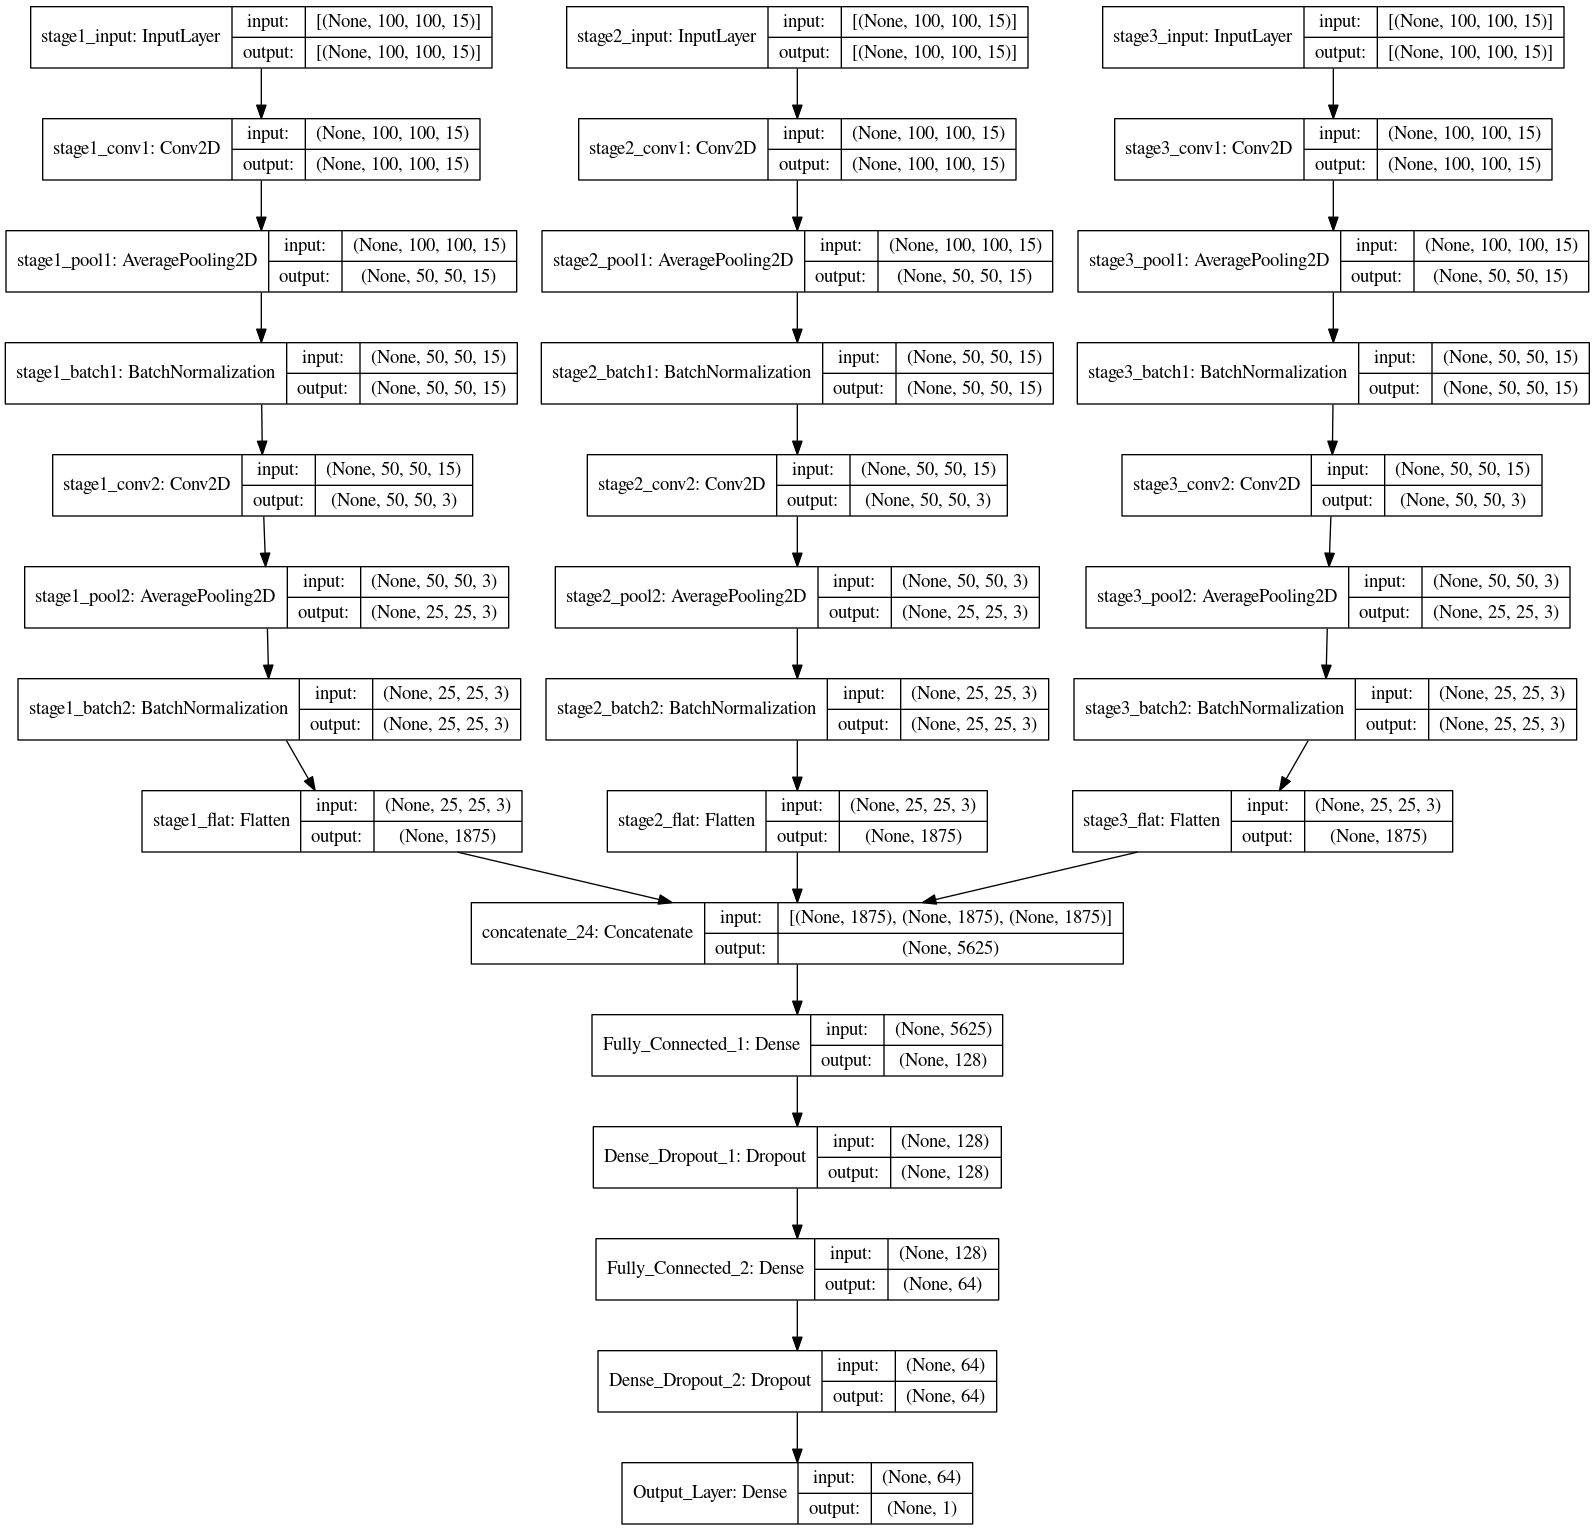

In [614]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/15
15/15 [==============================] - 12s 772ms/step - loss: 6940.0898 - root_mean_squared_error: 83.3072 - val_loss: 5416.1934 - val_root_mean_squared_error: 73.5948
Epoch 2/15
15/15 [==============================] - 11s 747ms/step - loss: 2356.3047 - root_mean_squared_error: 48.5418 - val_loss: 2752.5940 - val_root_mean_squared_error: 52.4652
Epoch 3/15
15/15 [==============================] - 11s 752ms/step - loss: 1504.6091 - root_mean_squared_error: 38.7893 - val_loss: 1316.1678 - val_root_mean_squared_error: 36.2790
Epoch 4/15
15/15 [==============================] - 11s 752ms/step - loss: 1372.7650 - root_mean_squared_error: 37.0508 - val_loss: 2234.2097 - val_root_mean_squared_error: 47.2674
Epoch 5/15
15/15 [==============================] - 11s 742ms/step - loss: 1101.0356 - root_mean_squared_error: 33.1819 - val_loss: 869.4523 - val_root_mean_squared_error: 29.4865
Epoch 6/15
15/15 [==============================] - 11s 757ms/step - loss: 872.6377 - root_mean_

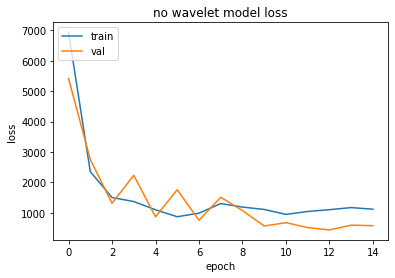

In [634]:
model.compile(
    loss = keras.losses.MeanSquaredError(), 
    optimizer = "adam",
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history = model.fit([stage_1_train, stage_2_train, stage_3_train], y_train, 
          batch_size = 5, 
          epochs = 15, 
          validation_data = ([stage_1_test, stage_2_test, stage_3_test], y_test), 
          )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('no wavelet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

[120. 125.  75. 120. 120.  95. 125. 125.  65.  90. 125.  80.  70. 125.
  70. 100.  90. 100.]
[100.82876   81.18574   78.859116 117.03021  102.05901  132.23311
  97.27104  119.46335   81.40579   89.90324   99.58718   98.36436
 105.091576  84.41233   36.411934  93.28212   89.89884   82.69413 ]


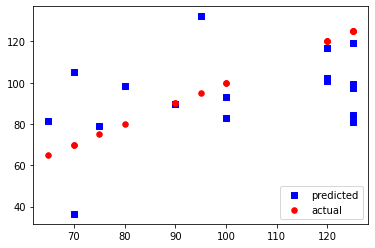

In [638]:
y_pred = model.predict([stage_1_test, stage_2_test, stage_3_test])
y_pred = y_pred.reshape(y_pred.shape[0])

print(y_test)
print(y_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_test, y_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_test, y_test, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

[ 85.  65. 145.  70.  75. 110. 115.  70. 105.  75. 135.  90.  65.  70.
 125.  70.  65. 155.  95.  80.  80.  85.  75.  90.  75. 120. 115. 110.
  75. 125.  70.  80.  75. 105. 100. 105. 100. 150. 105.  65. 105. 115.
 145.  85.  90.  65.  75. 100.  75. 160.  75. 120.  70.  75.  80. 110.
 120.  80.  65.  80.  80.  80.  65.  85.  65.  90.  70. 105.  65.  75.
  70.]
[ 67.1391    70.09588  156.80675   68.38076   76.23461  116.48824
 123.39434   83.73181  106.95902   72.634895 140.6939    97.73762
  70.256676  74.15455  128.98412   65.92097   48.747112 143.34259
  97.97648  107.90397   75.021324  78.962975  51.84333   87.527176
  70.32228  125.42689  113.618614 119.79787   88.58642  143.52779
  95.448875  51.68166   76.60812  101.24599  105.75079  130.1985
 127.25977  155.31068  107.94659   88.44903  125.68753  102.41006
 182.97095  109.61323   78.47695   97.88198   89.026535 119.29429
  98.37058  177.24635  100.90107   95.096466  67.53247   54.681732
  92.75243  131.78671  112.887764  84.92434

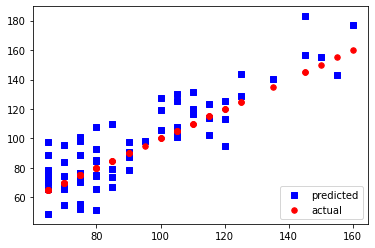

In [639]:
train_pred = model.predict([stage_1_train, stage_2_train, stage_3_train])
train_pred = train_pred.reshape(train_pred.shape[0])

print(y_train)
print(train_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_train, train_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_train, y_train, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

NameError: name 'y_test_spatial' is not defined

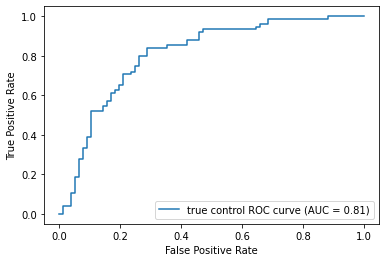

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='true control ROC curve')
display.plot()

plt.show()

In [34]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("true control confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

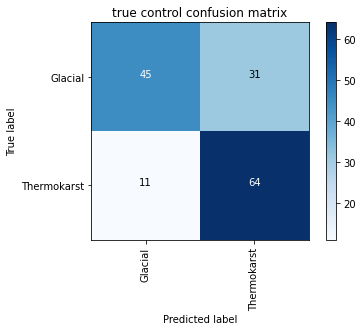

In [35]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()

In [19]:
import json

name = '/home/fun/data/AL202003' + '/profile.json'
f = open(name)
profile = json.load(f)
paths = profile['path']

valid_dates = []
for path in paths:
    valid_dates = np.append(valid_dates, str(path['date']))
    
imergs = glob.glob('/home/fun/data/AL182012/imerg_precipitation_*.npy', recursive = True)
imergs.sort()
imergs = imergs[0:3]
print(len(imergs))

valid = True

days = []

for imerg in imergs:
    days = np.append(days, imerg[-17:-9])
    
for day in days:
    if day not in valid_dates:
        valid = False
        
print(valid, valid_dates, days)

3
False ['20031204' '20031204' '20031205' '20031205' '20031205' '20031205'
 '20031206' '20031206' '20031206' '20031206'] ['20121021' '20121022' '20121022']
